# Audio Processing - 1
CSC6203 - T2 - Workshop 5

# Contents
1. Audio Utilities
  1. Frame
  1. Padding
  1. Fix Length
  1. Fix Frames
  1. Normalise
1. Audio Signal Representation
  1. Load and plot raw audio
  1. Compute Spectrogram
    1. Fourier Transform
    1. Spectrogram
  1. Extract MFCCs
1. Feature Extraction
  1. Zero Crossing Rate
  1. Spectral Centroid
  1. Spectral Bandwidth
  1. Chroma Features (Chroma STFT)
  1. RMS
1. Audio Preprocessing
  1. Noise Reduction
  1. Silence Removal
1. Audio Classification
  1. Speaker Identification (k-NN)
  1. Speech Commands (SVM)
1. Principal Component Analysis

# Audio Utilties

[Librosa Documentation](https://librosa.org/doc/0.10.2/util.html)

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create a simple signal
signal = np.arange(10.0)
print(signal)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


## Frame

In [9]:
# Create Frames from the signal
librosa.util.frame(signal, frame_length=3, hop_length=2, axis=0)


array([[0., 1., 2.],
       [2., 3., 4.],
       [4., 5., 6.],
       [6., 7., 8.]])

## Padding

In [13]:
# Add Padding to a signal using librosa.util.pad_center
librosa.util.pad_center(signal, size=15, axis=0)

array([0., 0., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 0., 0.])

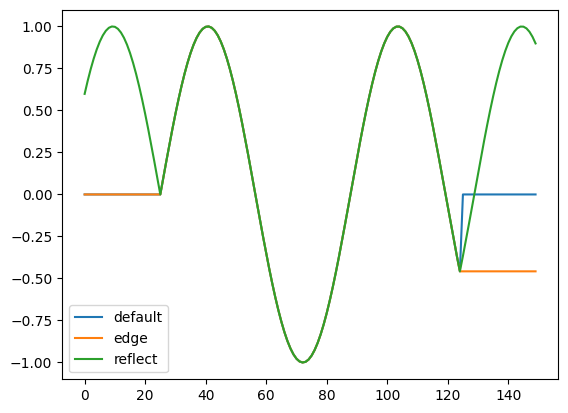

In [18]:
# create a sine signal
sine = np.sin(np.arange(0.0, 10.0, 0.1))

# Add Padding to the sine signal using librosa.util.pad_center
padded = librosa.util.pad_center(sine, size=150, axis=0)

# mode - edge
padded_edge = librosa.util.pad_center(sine, size=150, axis=0, mode='edge')

# mode - reflect
padded_reflect = librosa.util.pad_center(sine, size=150, axis=0, mode='reflect')

# Plot the signals to visualise
plt.figure()
plt.plot(padded, label='default')
plt.plot(padded_edge, label='edge')
plt.plot(padded_reflect, label='reflect')
plt.legend()
plt.show()

## Fix Length


In [20]:
# Fix the length of a signal
librosa.util.fix_length(signal, size=15, axis=0)

# mode - edge
librosa.util.fix_length(signal, size=15, axis=0, mode='edge')

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 9., 9., 9., 9., 9.])

## Fix Frames

In [24]:
# Fix frames based on x_min and x_max
librosa.util.fix_frames(signal, x_min=2, x_max=5)

array([2, 3, 4, 5])

## Normalise

In [25]:
# Normalise the signal
librosa.util.normalize(signal, axis=0)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

# Audio Signal Representation

In [26]:
import librosa.display
from scipy.fft import fft

## Load and plot raw signal

In [27]:
# Load a wav file from the file system
audio, sr = librosa.load('/content/Ses01M_script01_1_F000.wav')

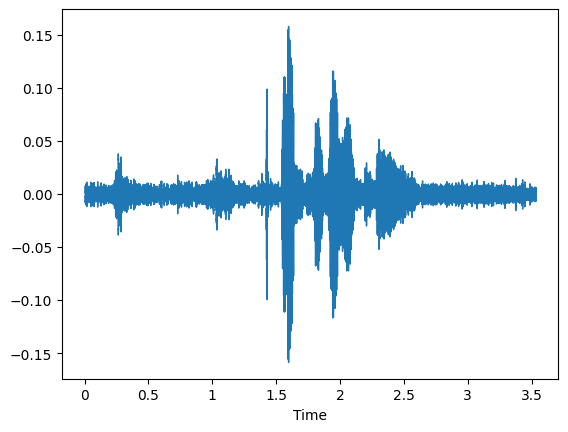

In [28]:
# Visualise the waveform with librosa display
plt.figure()
librosa.display.waveshow(audio, sr=sr)
plt.show()

In [29]:
ts = np.arange(len(audio))/sr
ts

array([0.00000000e+00, 4.53514739e-05, 9.07029478e-05, ...,
       3.53124717e+00, 3.53129252e+00, 3.53133787e+00])

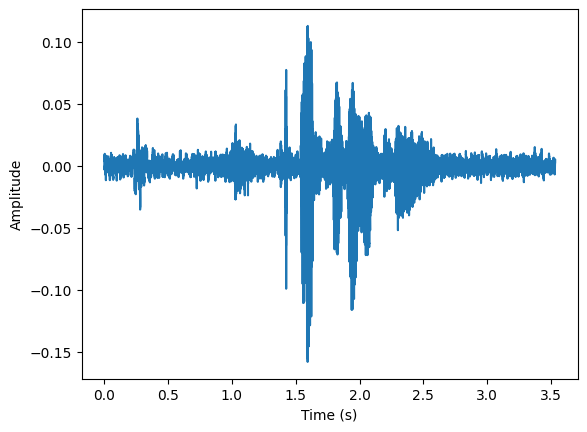

In [30]:
# Visualise the waveform with pyplot
plt.figure()
plt.plot(ts, audio)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Spectrogram

### Fourier Transform Audio

In [31]:
# Define the function to get Fourier Transform
def get_fft(audio, sampling_rate) :
  n = len(audio)
  T = 1/sampling_rate
  yf = fft(audio)
  xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
  x = xf
  y = 2.0/n * np.abs (yf[:n//2])
  return x,y

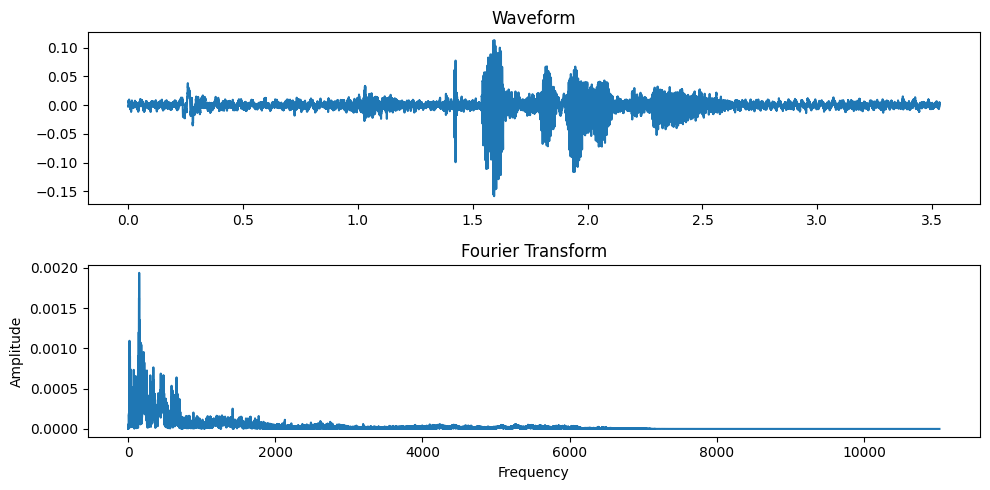

In [32]:
# Get the fourier transform of the audio
x,y = get_fft(audio, sr)


# Plot the FFT
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(audio))/sr, audio)
plt.title("Waveform")

plt.subplot(2, 1, 2)
plt.title("Fourier Transform")
plt.plot(x,y)
plt.ylabel("Amplitude")
plt.xlabel("Frequency")

plt.tight_layout()
plt.show()

### Spectrogram

#### Manual Implementation

In [35]:
# Define function to get spectrogram
def spectrogram(samples, sample_rate, stride_ms = 10.0, window_ms = 20.0, max_freq = 6000, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, shape = nshape, strides = nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.fft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = fft[:ind, :] + eps
    return specgram

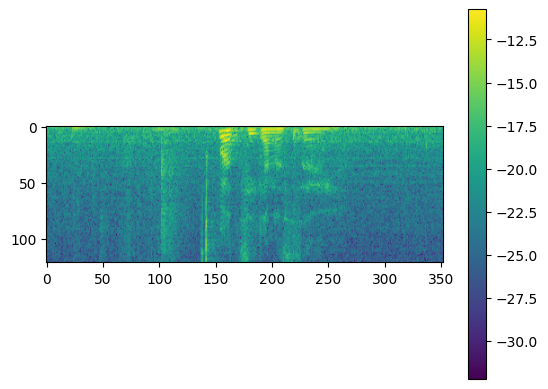

In [34]:
# use the spectrogram() method to get the spectrogram
spec = spectrogram(audio, sr)

# Visualise the spectrogram
plt.figure()
plt.imshow(spec)
plt.colorbar()
plt.show()

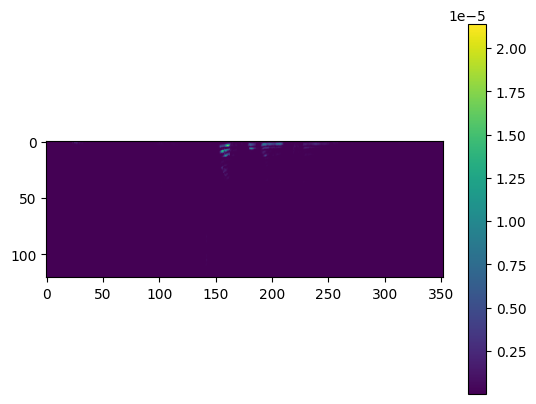

In [36]:
# Modify the spectrogram() method not to use np.log
spec = spectrogram(audio, sr)

plt.figure()
plt.imshow(spec)
plt.colorbar()
plt.show()

#### Using Librosa

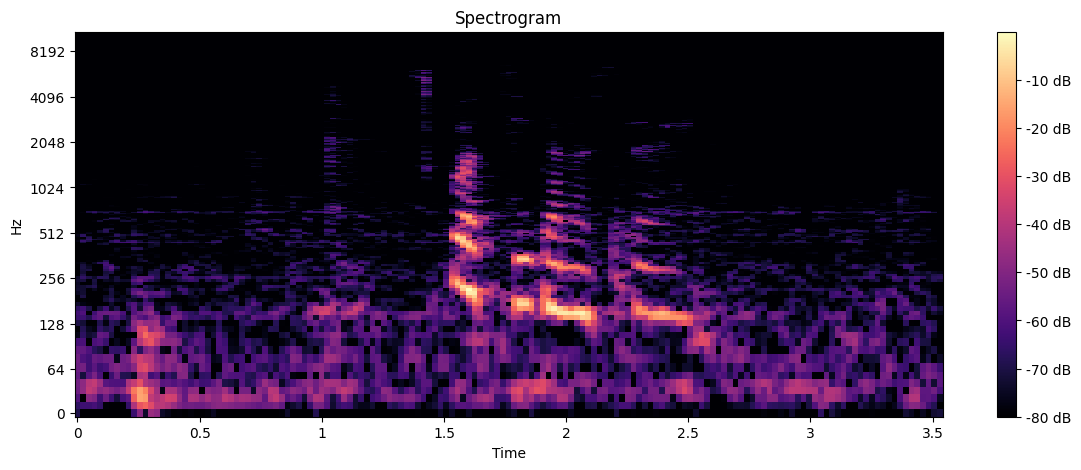

In [38]:
# Use librosa to get spectrogram

# Compute the spectrogram
D = np.abs(librosa.stft(audio))**2
S = librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.max)


# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCCs)

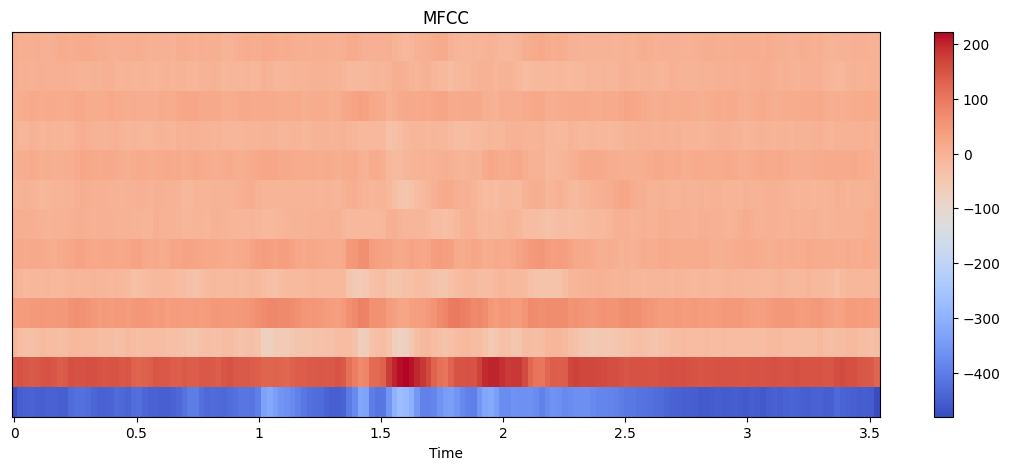

In [39]:
# Extract MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Display MFCCs
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

# Feature Extraction

## Zero Crossing Rate

In [43]:
zcr = librosa.feature.zero_crossing_rate(y=audio)
zcr.shape

(1, 153)

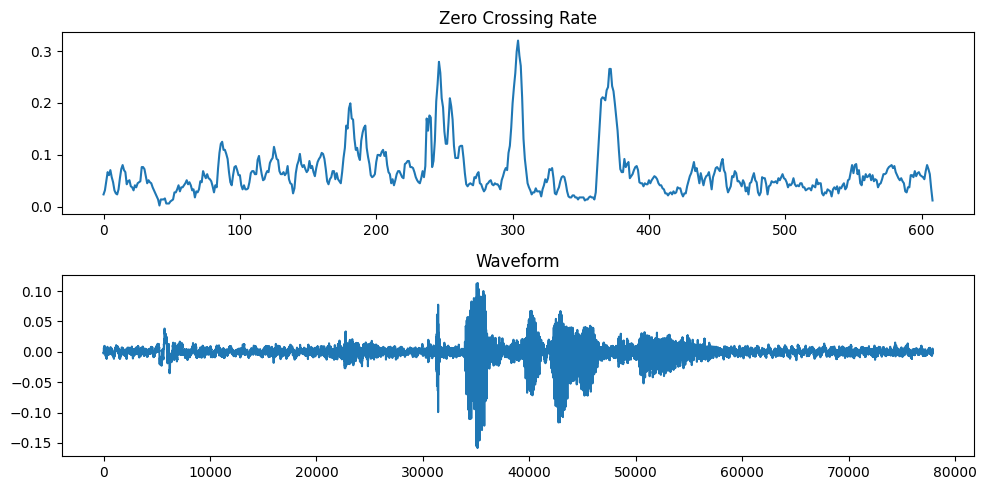

In [45]:
# Get ZCR from librosa.feature.zero_crossing_rate
zcr = librosa.feature.zero_crossing_rate(y=audio)[0]

# Adjust frame length, hop length
zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=512, hop_length=128)[0]

# Visualise ZCR
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(zcr)
plt.title('Zero Crossing Rate')

plt.subplot(2, 1, 2)
plt.plot(audio)
plt.title("Waveform")

plt.tight_layout()
plt.show()

## Spectral Centroid

In [47]:
# Get Spectral Centroid from librosa
spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr,)

In [49]:
spectral_centroid.shape

(1, 153)

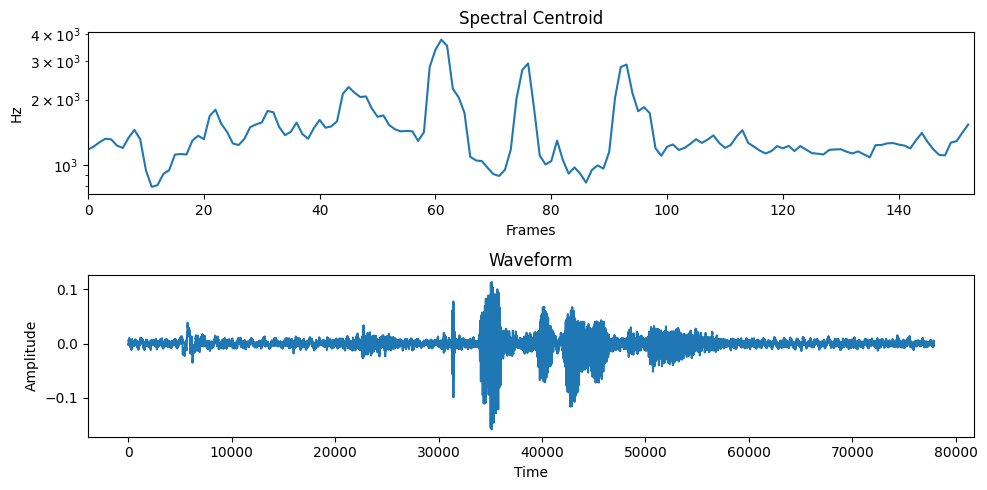

In [50]:
# Visualise

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(spectral_centroid.T, label='Spectral Centroid')
plt.ylabel('Hz')
plt.xlim([0, spectral_centroid.shape[-1]])
plt.title('Spectral Centroid')
plt.xlabel("Frames")

plt.subplot(2, 1, 2)
plt.plot(audio)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Spectral Bandwidth

In [51]:
# Get Spectral Bandwidth from librosa.feature.spectral_bandwidth

spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)

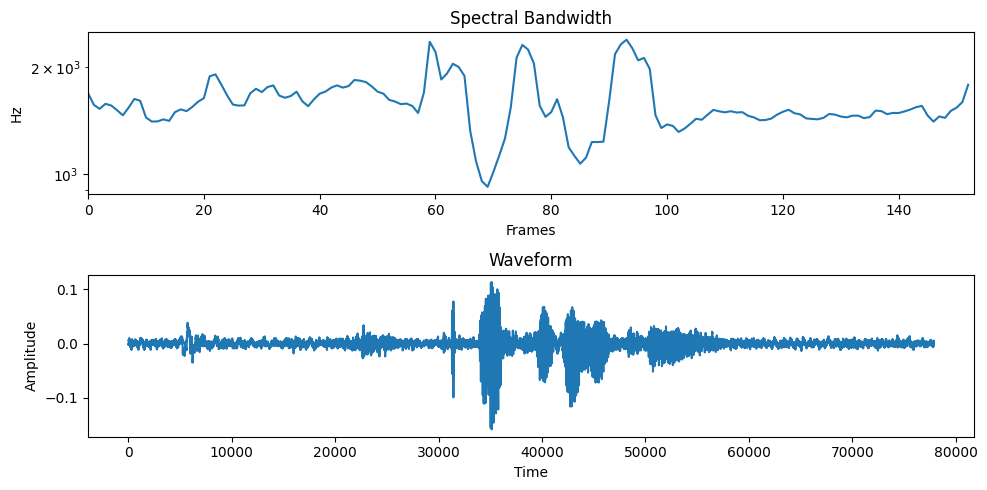

In [52]:
# Visualise

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(spectral_bandwidth.T, label='Spectral Bandwidth')
plt.ylabel('Hz')
plt.xlim([0, spectral_centroid.shape[-1]])
plt.title('Spectral Bandwidth')
plt.xlabel("Frames")

plt.subplot(2, 1, 2)
plt.plot(audio)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Chroma Features

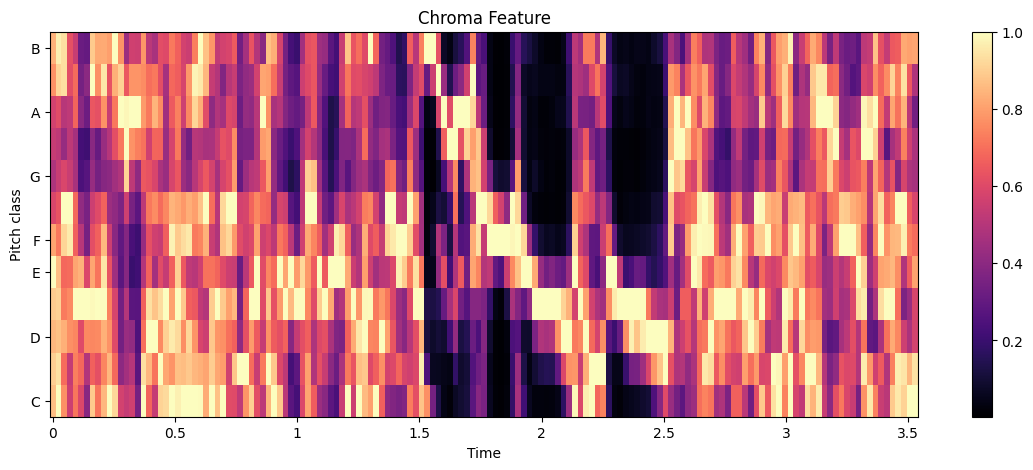

In [53]:
# Chroma Feature
chroma = librosa.feature.chroma_stft(y=audio, sr=sr)


# Visualise
plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Feature')
plt.show()

## root-mean-square (RMS)

In [57]:
# Get RMS value from librosa.feature.rms
rms = librosa.feature.rms(y=audio, hop_length=128)


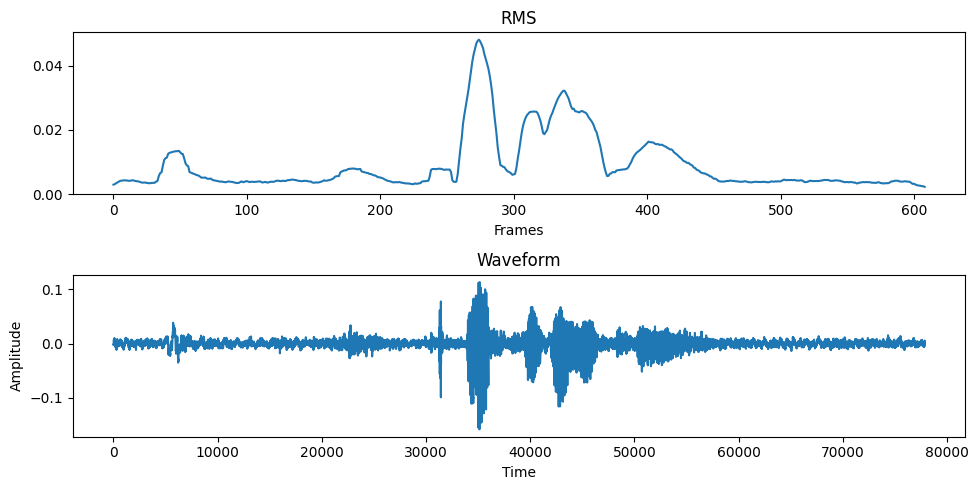

In [58]:
# Visualise

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(rms[0])
plt.title('RMS')
plt.xlabel("Frames")

plt.subplot(2, 1, 2)
plt.plot(audio)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Audio Preprocessing

In [64]:
!pip install noisereduce
import noisereduce as nr


## Noise Reduction

In [65]:
# Load the audio
audio, sr = librosa.load("/content/Ses01M_script01_1_F000.wav")

# Get noise reduced audio from nr
noise_reduced = nr.reduce_noise(y=audio, sr=sr)


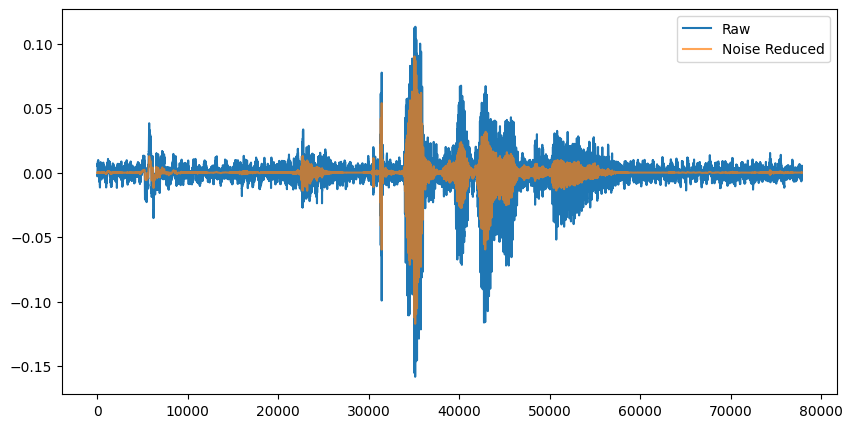

In [66]:
# Visualise
plt.figure(figsize=(10, 5))
plt.plot(audio, label='Raw')
plt.plot(noise_reduced, alpha=0.7, label='Noise Reduced')
plt.legend()
plt.show()

## Silence Removal

In [68]:
# Split the audio based on maximum db
intervals = librosa.effects.split(y=noise_reduced, top_db=20)

# Concatenate the audio without silence
silence_removed = np.concatenate([noise_reduced[start:end] for start, end in intervals])


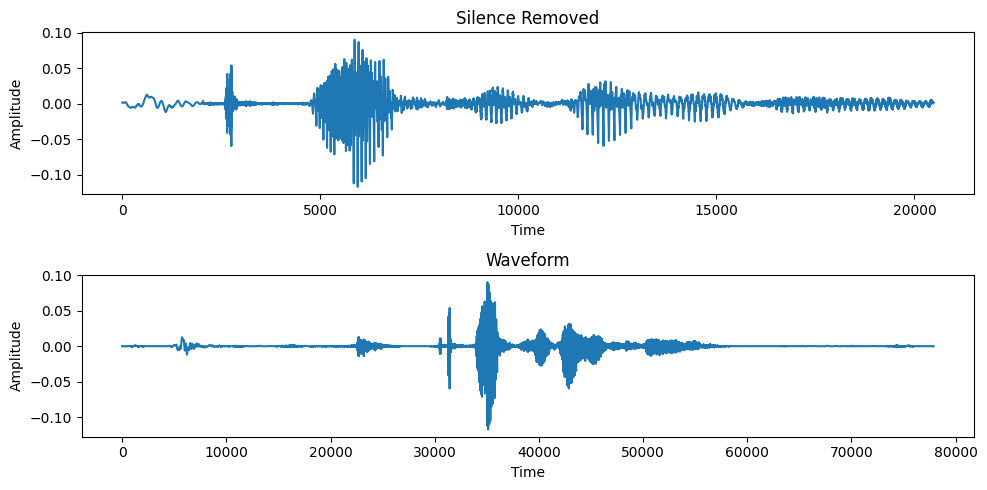

In [70]:
# Visualise
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(silence_removed)
plt.title("Silence Removed")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(noise_reduced)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


# Audio Classification

## Speaker Identification (k-NN)

[Dataset](https://www.kaggle.com/datasets/kongaevans/speaker-recognition-dataset)

In [ ]:
!mkdir speaker-identification
!cp '/content/drive/MyDrive/CSC6203/Data/speaker-identification.zip' '/content/speaker-identification/speaker-identification.zip'
!unzip '/content/speaker-identification/speaker-identification.zip' -d '/content/speaker-identification'
!rm -rf '/content/speaker-identification/16000_pcm_speeches/_background_noise_'
!rm -rf '/content/speaker-identification/16000_pcm_speeches/other'
!rm '/content/speaker-identification/16000_pcm_speeches/tf_Wav_reader.py'

In [61]:
import torch
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [75]:
# Use torchvision DatasetFolder to load the dataset from folder structure

# Define the loader function
def load_mfcc(path):
  # Load Audio
  audio, sr = librosa.load(path)

  # set the length of the loaded audio to be 1 sec
  audio = librosa.util.fix_length(audio, size=1*sr, axis=0)

  # Get MFCC
  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

  # K-NN classifier needs vector features, so reshape to a vector
  return mfcc.reshape(13*44)


# Define paths to the data directory
data_dir = '/content/speaker-identification/16000_pcm_speeches'

# Load the dataset
dataset = DatasetFolder(root=data_dir, loader=load_mfcc, extensions=('.wav'))

# Explore classes
classes, class_idx = dataset.find_classes(directory=data_dir)


In [76]:
class_idx

{'Benjamin_Netanyau': 0,
 'Jens_Stoltenberg': 1,
 'Julia_Gillard': 2,
 'Magaret_Tarcher': 3,
 'Nelson_Mandela': 4}

In [77]:
# Load the features and classes to an array
features = []
labels = []

for (d, l) in dataset:
  features.append(d)
  labels.append(l)

X = np.array(features)
Y = np.array(labels)

In [78]:
# Split to test and training
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [84]:
# Define and train k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)


KNeighborsClassifier(n_neighbors=3)

In [85]:
# Predict and evaluate
Y_pred = knn.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       310
           1       0.99      0.58      0.73       310
           2       0.90      0.88      0.89       283
           3       0.81      0.99      0.89       283
           4       0.91      1.00      0.95       315

    accuracy                           0.87      1501
   macro avg       0.88      0.87      0.86      1501
weighted avg       0.88      0.87      0.86      1501



## Speech Commands

In [86]:
!chmod +x download_speech_commands.sh
!./download_speech_commands.sh

--2024-06-13 04:15:07--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.96.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  41.2MB/s    in 37s     

2024-06-13 04:15:44 (38.7 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Deleting folder: _background_noise_
Deleting folder: bed
Deleting folder: bird
Deleting folder: cat
Deleting folder: dog
Deleting folder: down
Deleting folder: eight
Keeping folder: five
Keeping folder: four
Deleting folder: go
Deleting folder: happy
Deleting folder: house
Deleting folder: left
Deleting folder: marvin
Deleting folder: nine
Deleting folder: no
Deleting folder: off
D

In [87]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
# Set-up dataset and data loading functions
dataset_path = '/content/speech_commands'

keywords = ['one', 'two', 'three', 'four', 'five']

def load_audio_files(path, keywords):
    X = []
    y = []
    for keyword in keywords:
        keyword_path = os.path.join(path, keyword)
        for file in os.listdir(keyword_path):
            if file.endswith('.wav'):
                file_path = os.path.join(keyword_path, file)
                y.append(keyword)
                X.append(file_path)
    return X, y


def extract_features(file_paths):
    features = []
    for file_path in file_paths:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        features.append(mfccs_mean)
    return np.array(features)


In [89]:
# Load dataset
X_paths, y_labels = load_audio_files(dataset_path, keywords)


In [92]:
# Extract the features
X_features = extract_features(X_paths)


In [93]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

In [94]:
# Split to train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2, random_state=42)


In [96]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [97]:
# Train SVM classifier
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)


SVC(kernel='linear')

In [99]:
# Make predictions
y_pred = svm.predict(X_test)

In [101]:
# Evaluate classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy", accuracy)

print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy 0.5832628909551987
              precision    recall  f1-score   support

        five       0.60      0.65      0.62       455
        four       0.57      0.62      0.60       464
         one       0.53      0.53      0.53       477
       three       0.63      0.65      0.64       467
         two       0.59      0.48      0.53       503

    accuracy                           0.58      2366
   macro avg       0.58      0.59      0.58      2366
weighted avg       0.58      0.58      0.58      2366



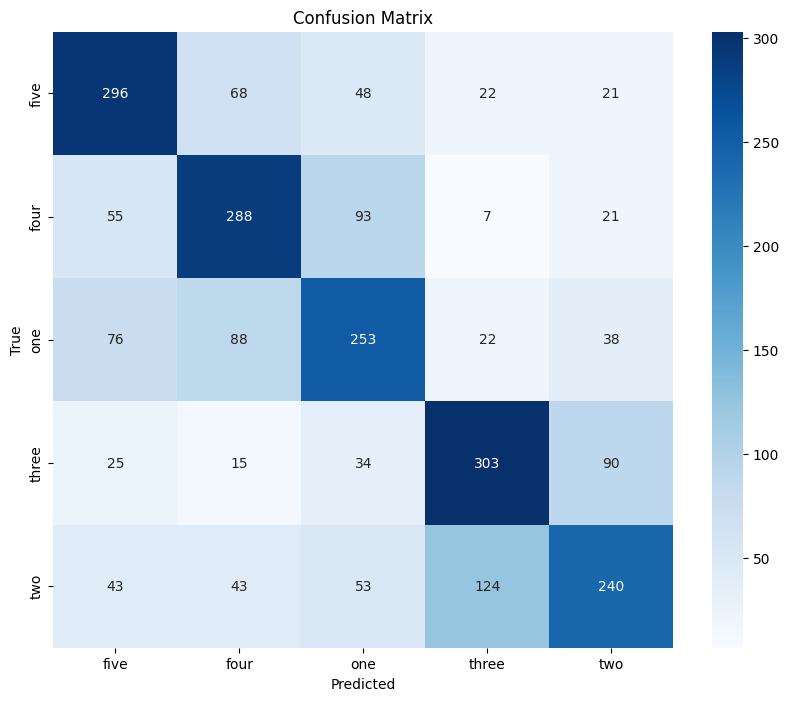

In [102]:
# Generate confusion matrix
cm = confusion_matrix(y_test,y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Principal Component Analysis (PCA)


In [103]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [111]:
# Load an audio file
y, sr = librosa.load("/content/speech_commands/three/0132a06d_nohash_2.wav")

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Transpose the MFCCs to have time frames as rows
mfccs = mfccs.T

In [105]:
mfccs.shape

(43, 13)

In [112]:
# Standardize the features
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs)

In [113]:
# Apply PCA
pca = PCA(n_components=2)
mfcc_pca = pca.fit_transform(mfccs_scaled)


In [109]:
mfcc_pca.shape

(43, 2)

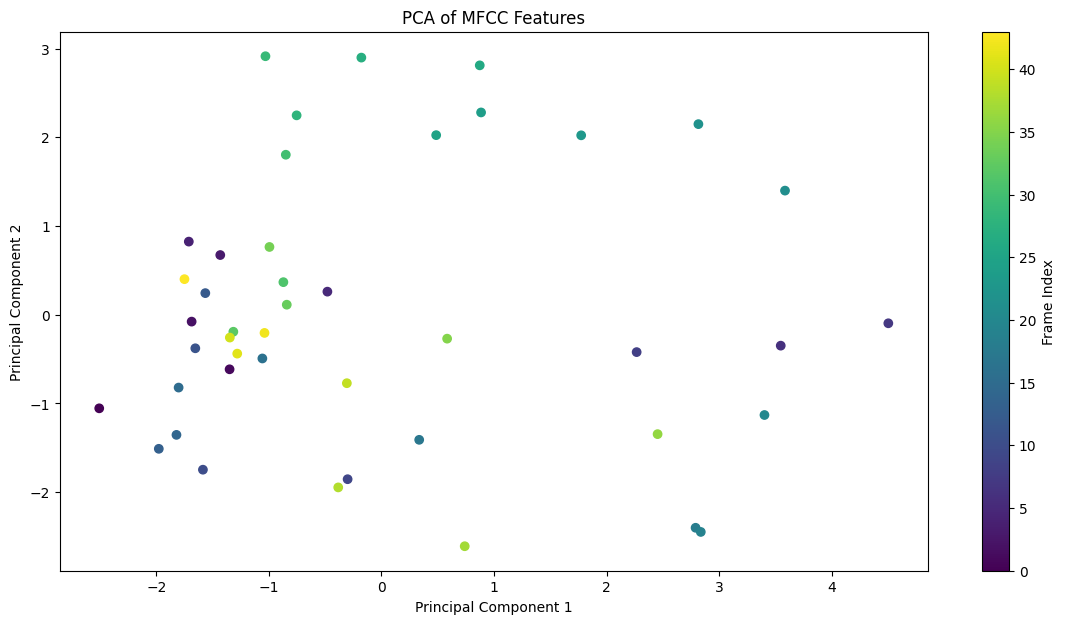

In [114]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.scatter(mfcc_pca[:, 0], mfcc_pca[:, 1], c=np.arange(mfcc_pca.shape[0]), cmap='viridis')
plt.colorbar(label='Frame Index')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MFCC Features')
plt.show()